In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# GPT1 vs Transformer
1. No encoder : encoder-decoder attention also deleted
2. Positional Embedding : input token * token embedding matrix + position embedding matrix
3. Loss : maximizing log likelihood of u_i over k previous tokens 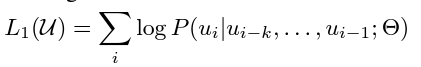
4. Input : question$answers

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
# 멀티헤드 어텐션 : n개의 head로 나누어 각 셀프 어텐션 처리
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size)
    key = self.split_heads(key,batch_size)
    value = self.split_heads(value,batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [6]:
# padding mask : 어느 부분이 패딩인지 알려주는 행렬
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# look ahead mask : 디코더에서 예측할 부분 이후의 단어를 보지 못하도록 가림
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

# 인코더 레이어, 인코더 삭제

In [8]:
"""# 인코더 하나의 레이어를 함수로 구현.
    # 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)"""

'# 인코더 하나의 레이어를 함수로 구현.\n    # 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.\ndef encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):\n  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)\n  attention = MultiHeadAttention(\n      d_model, num_heads, name="attention")({\n          \'query\': inputs,\n          \'key\': inputs,\n          \'value\': inputs,\n          \'mask\': padding_mask\n      })\n\n  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행\n  attention = tf.keras.layers.Dropout(rate=dropout)(attention)\n  attention = tf.keras.layers.LayerNormalization(\n      epsilon=1e-6)(inputs + attention)\n\n  # 두 번째 서브 레이어 : 2개의 완전연결층\n  outputs = tf.keras.layers.Dense(units=units, activation=\'relu\')(attention)\n  outputs = tf.keras.layers.Dense(units=d_model)(outputs)\n\n  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는

In [9]:
"""def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)"""

'def encoder(vocab_size,\n            num_layers,\n            units,\n            d_model,\n            num_heads,\n            dropout,\n            name="encoder"):\n  inputs = tf.keras.Input(shape=(None,), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 임베딩 레이어\n  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)\n  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))\n\n  # 포지셔널 인코딩\n  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)\n\n  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)\n\n  # num_layers만큼 쌓아올린 인코더의 층.\n  for i in range(num_layers):\n    outputs = encoder_layer(\n        units=units,\n        d_model=d_model,\n        num_heads=num_heads,\n        dropout=dropout,\n        name="encoder_layer_{}".format(i),\n    )([outputs, padding_mask])\n\n  return tf.keras.Model(\n      inputs=[inputs, padding_mask], outputs=outputs, name=name)'

# 디코더 레이어에서 인코더-디코더 어텐션 삭제

In [53]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재->두 개로 변경
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # 인코더 아웃풋 변수 삭제
    # enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과 LayerNormalization (+잔차 연결)
    #attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + inputs)

    """
      # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
      attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
              'query': attention1,
              'key': enc_outputs,
              'value': enc_outputs,
              'mask': padding_mask
          })
      # 마스크드 멀티 헤드 어텐션의 결과는
      # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
      attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
      attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)
    """

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과 LayerNormalization (+잔차 연결)
    #outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [54]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # 인코더 아웃풋 변수 삭제
    # enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

-----------------------
# 데이터 적용

In [12]:
# 데이터 path
data_path = "/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv"

In [13]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000

In [14]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  return sentence

In [15]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs,outputs = [],[]
    with open(data_path, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.split(',')
        inputs.append(preprocess_sentence(parts[0]))
        outputs.append(preprocess_sentence(parts[1])) # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용
    
    if (len(inputs) >= MAX_SAMPLES) :
        return inputs, outputs
    return inputs, outputs

In [16]:
# 데이터 로드
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11824
전체 샘플 수 : 11824


In [17]:
print('전처리 후의 0번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 0번째 답변 샘플: {}'.format(answers[0]))
print('전처리 후의 21번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 21번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 0번째 질문 샘플: Q
전처리 후의 0번째 답변 샘플: A
전처리 후의 21번째 질문 샘플: 가스비 비싼데 감기 걸리겠어
전처리 후의 21번째 답변 샘플: 따뜻하게 사세요 ! 


In [18]:
# 0번째 열 짤라줌
questions = questions[1:]
answers = answers[1:]
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


# Input 형태 변경
- question과 answer를 구분자 $로 연결

In [19]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [20]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [21]:
# 2개 추가해준 단어장 크기
VOCAB_SIZE = tokenizer.vocab_size + 2

In [22]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 10

In [29]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩, input과 output을 구분자 $ 로 합치기
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs = []
    separator = tokenizer.encode('$')
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용 & 구분자로 합치기
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1+separator+sentence2)

    # 최대 길이 10으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs

In [30]:
tknzed_inputs= tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문&답변 샘플 개수: {}'.format(len(tknzed_inputs)))

단어장의 크기 : 8149
필터링 후의 질문&답변 샘플 개수: 9132


In [61]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# inputs, outputs 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': tknzed_inputs,
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Transformer -> GPT1
- inputs 삭제
- 인코더 관련 전부 삭제


In [81]:
def gpt1(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt1"):
    # inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    """# 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)"""

    # 디코더에서 미래의 토큰을 마스크
    # 내부적으로 패딩 마스크도 포함
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(dec_inputs)

    """
      # 인코더
      enc_outputs = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
      )(inputs=[inputs, enc_padding_mask])
    """
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층-
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=dec_inputs, outputs=outputs, name=name)

In [82]:
# 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    8411392     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]         

# 손실 함수 재정의
- 이전 k개 토큰에 대한 i번째 토큰의 조건부 확률을 maximize

In [74]:
# 손실 함수
def loss_function(logits, labels):
    """y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)"""

    # Shift labels to the right to align them with the prediction positions
    shifted_labels = tf.roll(labels, shift=-1, axis=1)
    
    # Mask for padding or irrelevant tokens, typically using the token ID for padding (e.g., 0)
    mask = tf.cast(tf.not_equal(labels, 0), dtype=tf.float32)

    # Compute the cross-entropy loss, ignoring the padding tokens
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=shifted_labels)
    loss = loss * mask  # Apply mask
    
    return tf.reduce_mean(loss)

In [57]:
# Custom Learning rate Scheduling : 학습 초기에 lr을 급격히 높였다가 이후 천천히 수렴하게 함
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

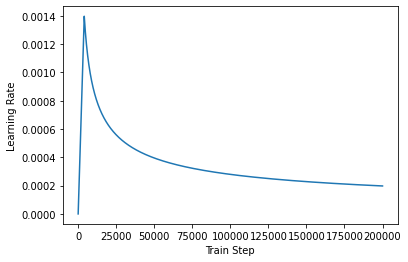

In [58]:
# 학습률 변화를 시각적으로 확인
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

---------------
# 모델

In [ ]:
# self-supervised learning
class gpt1(keras.Model):
    def __init__(self, decoder, **kwargs):
        self.decoder = decoder
        self.loss_tracker = keras.metrics.sparse_categorical_accuracy(name='loss')
        
        @property
        def metrics(self):
            return self.loss_tracker
        
        def train_step(self, data):
            with tf.GradientTape() as tape:
                

In [75]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function)

In [76]:
# 모델 훈련
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:622 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/utils.py:72 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['embedding/embeddings:0', 'attention/dense/kernel:0', 'attention/dense/bias:0', 'attention/dense_1/kernel:0', 'attention/dense_1/bias:0', 'attention/dense_2/kernel:0', 'attention/dense_2/bias:0', 'attention/dense_3/kernel:0', 'attention/dense_3/bias:0', 'layer_normalization/gamma:0', 'layer_normalization/beta:0', 'dense_4/kernel:0', 'dense_4/bias:0', 'dense_5/kernel:0', 'dense_5/bias:0', 'layer_normalization_1/gamma:0', 'layer_normalization_1/beta:0', 'attention/dense_6/kernel:0', 'attention/dense_6/bias:0', 'attention/dense_7/kernel:0', 'attention/dense_7/bias:0', 'attention/dense_8/kernel:0', 'attention/dense_8/bias:0', 'attention/dense_9/kernel:0', 'attention/dense_9/bias:0', 'layer_normalization_2/gamma:0', 'layer_normalization_2/beta:0', 'dense_10/kernel:0', 'dense_10/bias:0', 'dense_11/kernel:0', 'dense_11/bias:0', 'layer_normalization_3/gamma:0', 'layer_normalization_3/beta:0', 'attention/dense_12/kernel:0', 'attention/dense_12/bias:0', 'attention/dense_13/kernel:0', 'attention/dense_13/bias:0', 'attention/dense_14/kernel:0', 'attention/dense_14/bias:0', 'attention/dense_15/kernel:0', 'attention/dense_15/bias:0', 'layer_normalization_4/gamma:0', 'layer_normalization_4/beta:0', 'dense_16/kernel:0', 'dense_16/bias:0', 'dense_17/kernel:0', 'dense_17/bias:0', 'layer_normalization_5/gamma:0', 'layer_normalization_5/beta:0', 'attention/dense_18/kernel:0', 'attention/dense_18/bias:0', 'attention/dense_19/kernel:0', 'attention/dense_19/bias:0', 'attention/dense_20/kernel:0', 'attention/dense_20/bias:0', 'attention/dense_21/kernel:0', 'attention/dense_21/bias:0', 'layer_normalization_6/gamma:0', 'layer_normalization_6/beta:0', 'dense_22/kernel:0', 'dense_22/bias:0', 'dense_23/kernel:0', 'dense_23/bias:0', 'layer_normalization_7/gamma:0', 'layer_normalization_7/beta:0', 'attention/dense_24/kernel:0', 'attention/dense_24/bias:0', 'attention/dense_25/kernel:0', 'attention/dense_25/bias:0', 'attention/dense_26/kernel:0', 'attention/dense_26/bias:0', 'attention/dense_27/kernel:0', 'attention/dense_27/bias:0', 'layer_normalization_8/gamma:0', 'layer_normalization_8/beta:0', 'dense_28/kernel:0', 'dense_28/bias:0', 'dense_29/kernel:0', 'dense_29/bias:0', 'layer_normalization_9/gamma:0', 'layer_normalization_9/beta:0', 'attention/dense_30/kernel:0', 'attention/dense_30/bias:0', 'attention/dense_31/kernel:0', 'attention/dense_31/bias:0', 'attention/dense_32/kernel:0', 'attention/dense_32/bias:0', 'attention/dense_33/kernel:0', 'attention/dense_33/bias:0', 'layer_normalization_10/gamma:0', 'layer_normalization_10/beta:0', 'dense_34/kernel:0', 'dense_34/bias:0', 'dense_35/kernel:0', 'dense_35/bias:0', 'layer_normalization_11/gamma:0', 'layer_normalization_11/beta:0', 'attention/dense_36/kernel:0', 'attention/dense_36/bias:0', 'attention/dense_37/kernel:0', 'attention/dense_37/bias:0', 'attention/dense_38/kernel:0', 'attention/dense_38/bias:0', 'attention/dense_39/kernel:0', 'attention/dense_39/bias:0', 'layer_normalization_12/gamma:0', 'layer_normalization_12/beta:0', 'dense_40/kernel:0', 'dense_40/bias:0', 'dense_41/kernel:0', 'dense_41/bias:0', 'layer_normalization_13/gamma:0', 'layer_normalization_13/beta:0', 'attention/dense_42/kernel:0', 'attention/dense_42/bias:0', 'attention/dense_43/kernel:0', 'attention/dense_43/bias:0', 'attention/dense_44/kernel:0', 'attention/dense_44/bias:0', 'attention/dense_45/kernel:0', 'attention/dense_45/bias:0', 'layer_normalization_14/gamma:0', 'layer_normalization_14/beta:0', 'dense_46/kernel:0', 'dense_46/bias:0', 'dense_47/kernel:0', 'dense_47/bias:0', 'layer_normalization_15/gamma:0', 'layer_normalization_15/beta:0', 'attention/dense_48/kernel:0', 'attention/dense_48/bias:0', 'attention/dense_49/kernel:0', 'attention/dense_49/bias:0', 'attention/dense_50/kernel:0', 'attention/dense_50/bias:0', 'attention/dense_51/kernel:0', 'attention/dense_51/bias:0', 'layer_normalization_16/gamma:0', 'layer_normalization_16/beta:0', 'dense_52/kernel:0', 'dense_52/bias:0', 'dense_53/kernel:0', 'dense_53/bias:0', 'layer_normalization_17/gamma:0', 'layer_normalization_17/beta:0', 'attention/dense_54/kernel:0', 'attention/dense_54/bias:0', 'attention/dense_55/kernel:0', 'attention/dense_55/bias:0', 'attention/dense_56/kernel:0', 'attention/dense_56/bias:0', 'attention/dense_57/kernel:0', 'attention/dense_57/bias:0', 'layer_normalization_18/gamma:0', 'layer_normalization_18/beta:0', 'dense_58/kernel:0', 'dense_58/bias:0', 'dense_59/kernel:0', 'dense_59/bias:0', 'layer_normalization_19/gamma:0', 'layer_normalization_19/beta:0', 'attention/dense_60/kernel:0', 'attention/dense_60/bias:0', 'attention/dense_61/kernel:0', 'attention/dense_61/bias:0', 'attention/dense_62/kernel:0', 'attention/dense_62/bias:0', 'attention/dense_63/kernel:0', 'attention/dense_63/bias:0', 'layer_normalization_20/gamma:0', 'layer_normalization_20/beta:0', 'dense_64/kernel:0', 'dense_64/bias:0', 'dense_65/kernel:0', 'dense_65/bias:0', 'layer_normalization_21/gamma:0', 'layer_normalization_21/beta:0', 'attention/dense_66/kernel:0', 'attention/dense_66/bias:0', 'attention/dense_67/kernel:0', 'attention/dense_67/bias:0', 'attention/dense_68/kernel:0', 'attention/dense_68/bias:0', 'attention/dense_69/kernel:0', 'attention/dense_69/bias:0', 'layer_normalization_22/gamma:0', 'layer_normalization_22/beta:0', 'dense_70/kernel:0', 'dense_70/bias:0', 'dense_71/kernel:0', 'dense_71/bias:0', 'layer_normalization_23/gamma:0', 'layer_normalization_23/beta:0', 'outputs/kernel:0', 'outputs/bias:0'].
